# Part 3.1: Enchancement with a biLSTM model

### Install and import needed libraries

In [1]:
!python -m venv .venv
!source .venv/bin/activate
!pip install -r requirements.txt
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 10.6 MB/s  0:00:01m0:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data, datasets
from torchtext.vocab import Vocab
from collections import Counter
import random

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns


import matplotlib.pyplot as plt

SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)


### Perform train-test split on dataset

In [3]:
# === Load embeddings & vocab from Part 1 ===
enhanced_embeddings = torch.load('enhanced_embeddings.pt')
vocab_state = torch.load('vocab_state.pt', weights_only=False)

vocab_size_part1, embedding_dim = enhanced_embeddings.shape
print(f"Enhanced embeddings: {enhanced_embeddings.shape}")
print(f"Vocab size (from Part 1): {vocab_state['vocab_size']}")

# === TEXT/LABEL match Part 1 ===

TEXT = data.Field(
    tokenize='spacy',
    tokenizer_language='en_core_web_sm',
    include_lengths=True,
    lower=True,          
    batch_first=False    
)
LABEL = data.LabelField()

# Rebuild dataset pipeline like Part 2

train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

# Split train/val 80/20 (deterministic with seed)
train_data, val_data = train_data.split(split_ratio=0.8, random_state=random.seed(SEED))

# Re-attach saved vocab to TEXT and LABEL to ensure consistent indices
itos = vocab_state['itos']
stoi = vocab_state['stoi']
vectors = enhanced_embeddings

# Rebuild TEXT.vocab using saved stoi/itos
vocab = Vocab(counter=Counter(), specials=['<unk>', '<pad>'])
vocab.itos = itos
vocab.stoi = stoi

TEXT.vocab = vocab
LABEL.build_vocab(train_data)

PAD_IDX = TEXT.vocab.stoi['<pad>'] if '<pad>' in TEXT.vocab.stoi else 1

BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    device=device
)

print(f"Device: {device}")
print(f"Batch size: {BATCH_SIZE}")


Enhanced embeddings: torch.Size([7435, 300])
Vocab size (from Part 1): 7435
Device: cpu
Batch size: 64


### Create BiLSTM Class for classification later

In [4]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, num_layers=1, dropout=0.5, bidirectional=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )
        self.dropout = nn.Dropout(dropout)
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional

        feat_dim = hidden_dim * (2 if bidirectional else 1)
        self.fc = nn.Linear(feat_dim, output_dim)

    def forward(self, text):
        # text: [seq_len, batch]
        embedded = self.embedding(text)            
        outputs, hidden = self.lstm(embedded)       
        pooled, _ = outputs.max(dim=0)             
        out = self.dropout(pooled)
        logits = self.fc(out)                      
        return logits


### Functions to train and evaluate model on each epoch

In [5]:
def train_epoch(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss, epoch_acc = 0.0, 0.0
    for batch in iterator:
        text, _ = batch.text
        labels = batch.label
        optimizer.zero_grad()
        preds = model(text)
        loss = criterion(preds, labels)
        acc = (preds.argmax(1) == labels).float().mean()

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # small clip
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

def eval_epoch(model, iterator, criterion):
    model.eval()
    epoch_loss, epoch_acc = 0.0, 0.0
    with torch.no_grad():
        for batch in iterator:
            text, _ = batch.text
            labels = batch.label
            preds = model(text)
            loss = criterion(preds, labels)
            acc = (preds.argmax(1) == labels).float().mean()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [ ]:
VOCAB_SIZE = len(TEXT.vocab)
EMBEDDING_DIM = enhanced_embeddings.shape[1]
HIDDEN_DIM = 128
OUTPUT_DIM = len(LABEL.vocab)
MAX_LAYERS = 3 # Prevent overfitting
DROPOUT = 0.5

BEST_VAL_ACC = -1.0
BEST_LAYER = -1
BEST_EPOCH = -1

LEARNING_RATE = 8e-4
N_EPOCHS = 30
PATIENCE = 5 # stop if next 5 epochs does not produce better accuracy
WEIGHT_DECAY = 5e-5

In [ ]:
def print_eval_results(model,
                       optimizer,
                       criterion
                       ):
    

    global BEST_VAL_ACC, BEST_LAYER, BEST_EPOCH
    global N_EPOCHS, PATIENCE, NUM_LAYERS
    current_best_val_acc = -1.0
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    patience_counter = 0
    produced_best = False

    print(f"{'Epoch':<6} {'TrainLoss':<10} {'TrainAcc':<10} {'ValLoss':<10} {'ValAcc':<10}")

    for epoch in range(1, N_EPOCHS+1):
        tr_l, tr_a = train_epoch(model, train_iterator, optimizer, criterion)
        va_l, va_a = eval_epoch(model, val_iterator, criterion)

        train_losses.append(tr_l); train_accs.append(tr_a)
        val_losses.append(va_l); val_accs.append(va_a)

        tag = ""
        glob_tag = ""
        if va_a > current_best_val_acc:
            current_best_val_acc = va_a
            if va_a > BEST_VAL_ACC:
                produced_best = True
                BEST_VAL_ACC = va_a
                BEST_LAYER = NUM_LAYERS
                BEST_EPOCH = epoch
                glob_tag = " & CURRENT BEST"
                torch.save(model.state_dict(), 'best_biLSTM.pt')
            patience_counter = 0
            tag = f" <-- BEST FOR LAYER={NUM_LAYERS}"
        else:
            patience_counter += 1

        print(f"{epoch:<6} {tr_l:<10.4f} {tr_a:<10.4f} {va_l:<10.4f} {va_a:<10.4f}{tag}{glob_tag}")

        if patience_counter >= PATIENCE:
            # Stop training if accuracy on validaiton set does not improve
            print(f"Early stopping at epoch {epoch}.")
            break

    return produced_best, train_losses, train_accs, val_losses, val_accs


In [8]:
TRAIN_LOSSES, VAL_LOSSES, TRAIN_ACCS, VAL_ACCS = [], [], [], []

PROD_BEST = False

for NUM_LAYERS in range(1, MAX_LAYERS + 1):

    cur_model = BiLSTMClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX, num_layers=NUM_LAYERS, dropout=DROPOUT, bidirectional=True)
    optimizer = optim.Adam(cur_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss().to(device)
    # set pretrained weights
    with torch.no_grad():
        cur_model.embedding.weight[:VOCAB_SIZE, :].copy_(enhanced_embeddings)

    cur_model.embedding.weight.requires_grad = True  
    cur_model = cur_model.to(device)

    parameters_count = sum(p.numel() for p in cur_model.parameters() if p.requires_grad)

    print("\nModel: BiLSTM")
    print(f"Vocab size: {VOCAB_SIZE}, Emb dim: {EMBEDDING_DIM}, Hidden: {HIDDEN_DIM}, Layers: {NUM_LAYERS}, Bi: True")
    print(f"Output dim: {OUTPUT_DIM}, Trainable params: {parameters_count:,}")

    prod_best, tl, ta, vl, va = print_eval_results(model=cur_model, optimizer=optimizer, criterion=criterion)

    if prod_best:
        BEST_MODEL = cur_model
        TRAIN_LOSSES = tl
        TRAIN_ACCS = ta
        VAL_LOSSES = vl
        VAL_ACCS = va

print(f"Layer with best result: {BEST_LAYER}")
print(f"Epoch with best result: {BEST_EPOCH}")
print(f"Validation accuracy: {BEST_VAL_ACC}")


Model: BiLSTM
Vocab size: 7435, Emb dim: 300, Hidden: 128, Layers: 1, Bi: True
Output dim: 6, Trainable params: 2,672,362
Epoch  TrainLoss  TrainAcc   ValLoss    ValAcc    
1      1.3932     0.4596     0.9694     0.6649     <-- BEST FOR LAYER=1 & CURRENT BEST
2      0.7010     0.7543     0.6655     0.7448     <-- BEST FOR LAYER=1 & CURRENT BEST
3      0.4780     0.8375     0.5611     0.8064     <-- BEST FOR LAYER=1 & CURRENT BEST
4      0.3365     0.8877     0.4787     0.8368     <-- BEST FOR LAYER=1 & CURRENT BEST
5      0.2025     0.9400     0.5091     0.8333    
6      0.1325     0.9611     0.5585     0.8359    
7      0.0864     0.9760     0.5143     0.8611     <-- BEST FOR LAYER=1 & CURRENT BEST
8      0.0690     0.9792     0.4523     0.8516    
9      0.0458     0.9882     0.6097     0.8516    
10     0.0285     0.9916     0.6520     0.8490    
11     0.0292     0.9928     0.6068     0.8559    
12     0.0185     0.9959     0.5982     0.8550    
Early stopping at epoch 12.

Model

## Training Loss Curve and Validation Accuracy Curve across epochs = 1 to 13

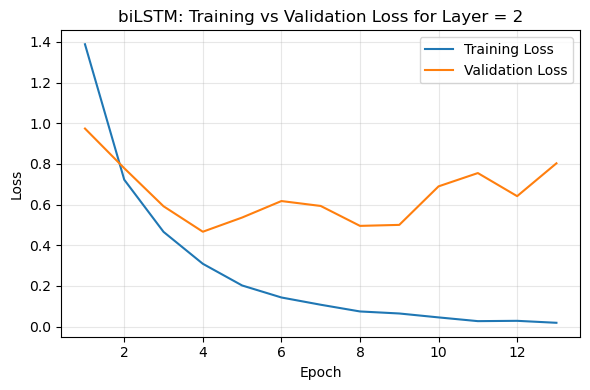

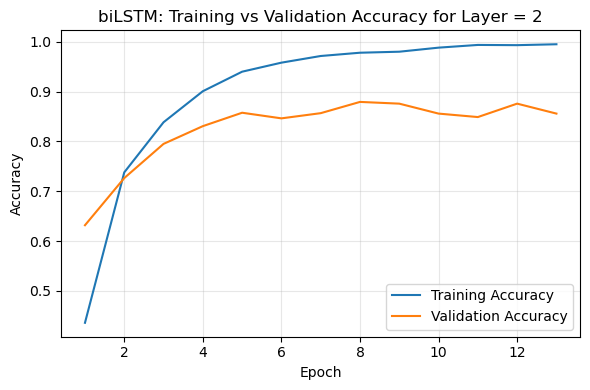

In [ ]:

epochs_range = range(1, len(TRAIN_LOSSES)+1)

plt.figure(figsize=(6,4))
plt.plot(epochs_range, TRAIN_LOSSES, label='Training Loss')
plt.plot(epochs_range, VAL_LOSSES, label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'biLSTM: Training vs Validation Loss for Layer = {BEST_LAYER}')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('biLSTM-loss-curve.png', dpi=300)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_range, TRAIN_ACCS, label='Training Accuracy')
plt.plot(epochs_range, VAL_ACCS, label='Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'biLSTM: Training vs Validation Accuracy for Layer = {BEST_LAYER}')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('biLSTM-accuracy-curve.png', dpi=300)
plt.show()


## Perform classification on test set

Test Loss: 0.4807 | Test Acc: 0.8821

Classification Report:
              precision    recall  f1-score   support

         HUM     0.9649    0.8462    0.9016        65
        ENTY     0.8242    0.7979    0.8108        94
        DESC     0.8204    0.9928    0.8984       138
         NUM     1.0000    0.8496    0.9187       113
         LOC     0.8659    0.8765    0.8712        81
        ABBR     1.0000    0.7778    0.8750         9

    accuracy                         0.8820       500
   macro avg     0.9126    0.8568    0.8793       500
weighted avg     0.8911    0.8820    0.8821       500



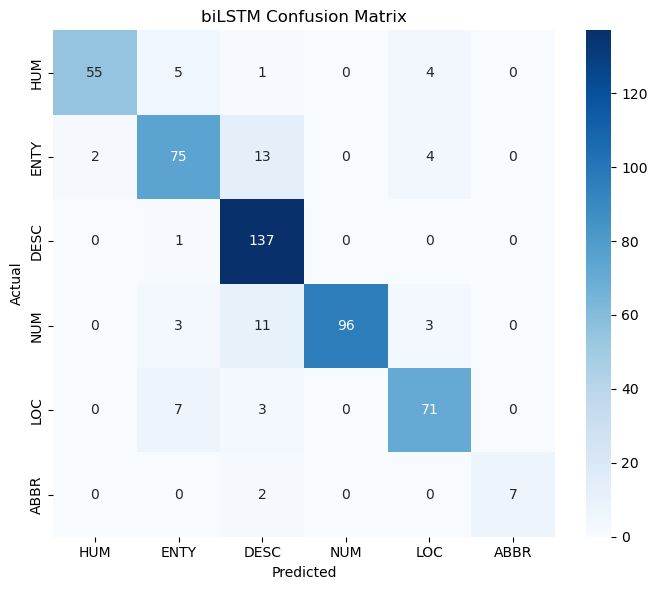

In [ ]:
# Load best checkpoint
state = torch.load('best_biLSTM.pt', map_location=device)

BEST_MODEL.load_state_dict(state)

# Test eval
test_loss, test_acc = eval_epoch(BEST_MODEL, test_iterator, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

# Detailed metrics
def get_predictions(model, iterator):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in iterator:
            text, _ = batch.text
            y = batch.label
            p = model(text).argmax(1).cpu().numpy()
            preds.extend(list(p)); labels.extend(list(y.cpu().numpy()))
    return np.array(preds), np.array(labels)

preds, labels = get_predictions(BEST_MODEL, test_iterator)

print("\nClassification Report:")
print(classification_report(labels, preds, target_names=LABEL.vocab.itos, digits=4))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABEL.vocab.itos, yticklabels=LABEL.vocab.itos)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('biLSTM Confusion Matrix')
plt.tight_layout(); plt.savefig('biLSTM-confusion-matrix.png', dpi=300)
plt.show()


In [12]:
# get preds/labels for biLSTM
preds, labels = get_predictions(BEST_MODEL, test_iterator)
label_names = list(LABEL.vocab.itos)  # order matches indices 0..C-1



# ---- Topic-wise accuracy ----
print("\n" + "="*64)
print("biLSTM — TOPIC-WISE ACCURACY (per-class)")
print("="*64)

per_class_rows = []
for i, name in enumerate(label_names):
    mask = (labels == i)
    n = int(mask.sum())
    if n == 0:
        acc = float('nan')
        correct = 0
    else:
        correct = int((preds[mask] == labels[mask]).sum())
        acc = correct / n
    per_class_rows.append((name, n, correct, acc))

# pretty print
for name, n, correct, acc in per_class_rows:
    print(f"{name:<8} | samples: {n:>3d} | correct: {correct:>3d} | accuracy: {acc*100:6.2f}%")

# macro / micro summary
macro_acc = np.nanmean([acc for _,_,_,acc in per_class_rows])
micro_acc = (preds == labels).mean()
print("-"*64)
print(f"Macro-average accuracy: {macro_acc*100:.2f}%")
print(f"Micro-average accuracy: {micro_acc*100:.2f}%  (equals overall test accuracy)")


biLSTM — TOPIC-WISE ACCURACY (per-class)
HUM      | samples:  65 | correct:  55 | accuracy:  84.62%
ENTY     | samples:  94 | correct:  75 | accuracy:  79.79%
DESC     | samples: 138 | correct: 137 | accuracy:  99.28%
NUM      | samples: 113 | correct:  96 | accuracy:  84.96%
LOC      | samples:  81 | correct:  71 | accuracy:  87.65%
ABBR     | samples:   9 | correct:   7 | accuracy:  77.78%
----------------------------------------------------------------
Macro-average accuracy: 85.68%
Micro-average accuracy: 88.20%  (equals overall test accuracy)


### **Part 3.1 (biLSTM) – Comments on Accuracy**



| Model Type             |  Validation Accuracy | Topic-wise Accuracy Range (Test set)| Mean Topic-wise Accuracy (Test set)|
|------------------------|-------------------:|---------------------------:          |---------------------------:          |
| Original RNN Model     | 0.8889             | 0.667 – 0.986                        | 0.8420 |
| Enhanced biLSTM Model  | 0.8793             | 0.778 – 0.993                        | 0.8568 |


On the validation set:
- Comparing the best parameters for each model type...
    - Both models' perfomance are comparable with validation accuracy around 89%
    - biLSTM's performance peaked at epoch = 8
    - RNN's performance peaked at epoch = 11


On the test set:
- A more stable and uniform topic-wise accuracy on the biLSTM model compared to RNN model
    - Macro-average of 84.20% on the RNN model
    - Range of 31.9 percentage points on the RNN model
    - Macro-average of 86.68% on the biLSTM model
    - Range of 21.5 percentage points on the biLSTM model
    
- biLSTM model even achieved a 99.3% on questions with the DESC label
- This is achieved with stacking 2 LSTM models on top of each other
- Likely less overfitting than original RNN model due to smaller spread of results
